In [508]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [509]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20240929-170910_257faf7cba2e8d451de1c33be60b9445'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [510]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [511]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [512]:
example_id = 1

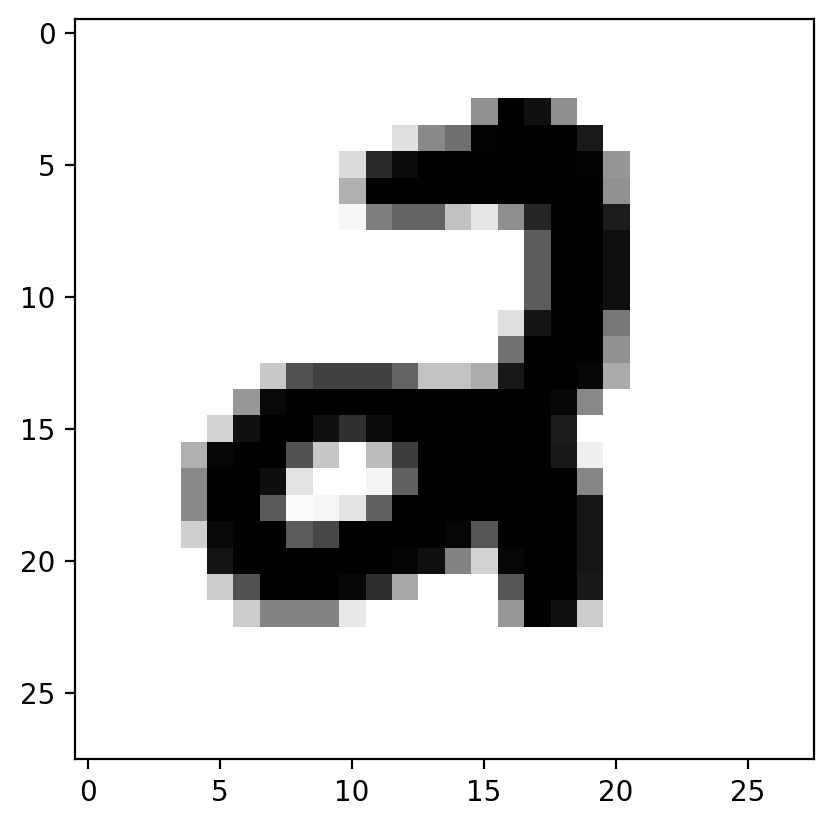

In [513]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

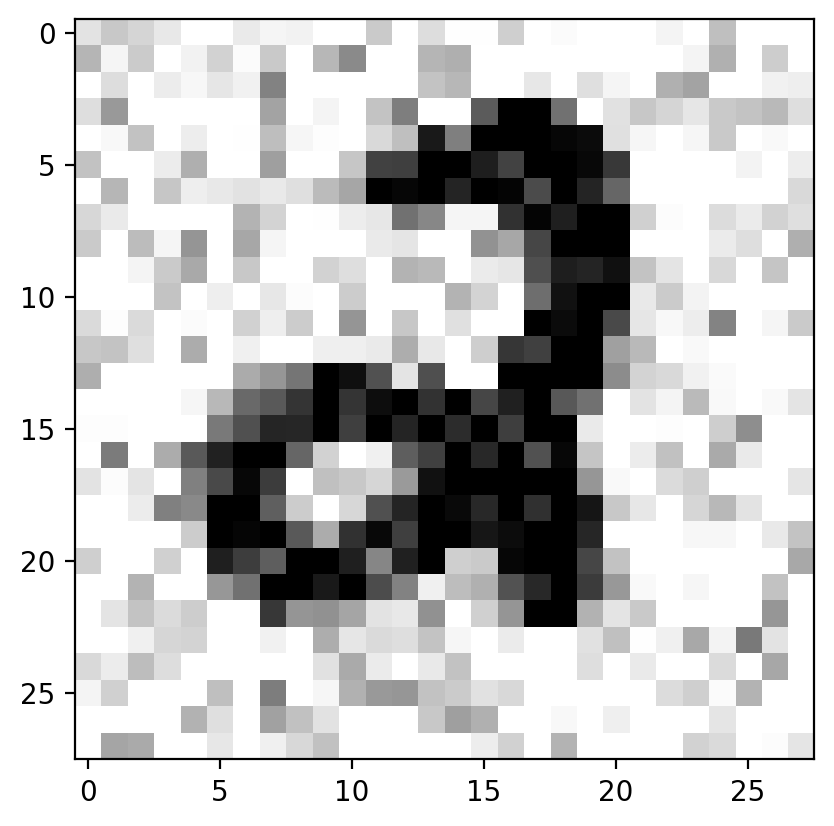

In [514]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [515]:
train_y.iloc[example_id]

digit    2
Name: 1, dtype: uint8

In [516]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

In [517]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.initializers import HeNormal
def build_model(encoder_width: int, learning_rate_log: float) -> tf.keras.Model:
    mlflow.log_param('encoder_width', encoder_width)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    
    # IMPORTANT: This is an example of a very simple undercomplete autoencoder.
    # In other words, you will probably need to tweak these lines of code.
    
    layers = [
        # Encoder: 50 nodes, Gaussian Error Linear Unit activation
        Dense(
            units=encoder_width, 
            activation='gelu', 
            input_shape=(28 * 28,)
        ),
        BatchNormalization(),
        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (dark) and 1 (bright).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(learning_rate=float(10 ** learning_rate_log),
        )
        , loss='mean_squared_error',
    )
    return autoencoder


In [518]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')

In [519]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.
from collegium.foundation.callbacks import MlflowCallback
import tempfile


def train_denoise_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X.values,  
        y=train_clean_X.values, 

        epochs=epochs,  
        batch_size=128, 
        shuffle=True,  
        validation_data=(validate_noisy_X.values, validate_clean_X.values), 
        callbacks=[MlflowCallback()], 
        verbose=verbose  
    )
    
   
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

In [520]:
# See MLFlow docs for more API examples.
# https://mlflow.org/docs/latest/python_api/mlflow.html

import mlflow
mlflow.set_experiment('assignment_01')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [521]:
mlflow.get_experiment_by_name('assignment_01')

<Experiment: artifact_location='file:///app/mlflow/702207067119863856', creation_time=1728244155227, experiment_id='702207067119863856', last_update_time=1728244155227, lifecycle_stage='active', name='assignment_01', tags={}>

In [523]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
import numpy as np
import tensorflow as tf
import mlflow

# Setting the seeds for reproducibility without resetting later
np.random.seed(11)
tf.random.set_seed(11)

# Assuming you have your model-building and training functions defined
# build_model() and train_denoise_model() should already exist

with mlflow.start_run():
    autoencoder = build_model(encoder_width=200, learning_rate_log=-3)
    history = train_denoise_model(autoencoder, epochs=10)

    # Logging the loss at each epoch
    for epoch, loss in enumerate(history.history['loss']):
        print(f"Epoch {epoch + 1}, Loss: {loss}")
        mlflow.log_metric("loss", loss, step=epoch + 1)

    # Optionally, you can log the final model
    mlflow.keras.log_model(autoencoder, "autoencoder_model")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


2024/10/06 21:41:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Epoch 1, Loss: 0.04777636379003525
Epoch 2, Loss: 0.0068474807776510715
Epoch 3, Loss: 0.005137693602591753
Epoch 4, Loss: 0.004532534163445234
Epoch 5, Loss: 0.004257372114807367
Epoch 6, Loss: 0.004095043987035751
Epoch 7, Loss: 0.004005170427262783
Epoch 8, Loss: 0.003901929361745715
Epoch 9, Loss: 0.003852802561596036
Epoch 10, Loss: 0.003809320041909814
INFO:tensorflow:Assets written to: /tmp/tmpk7wfp41f/model/data/model/assets


2024/10/06 21:41:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


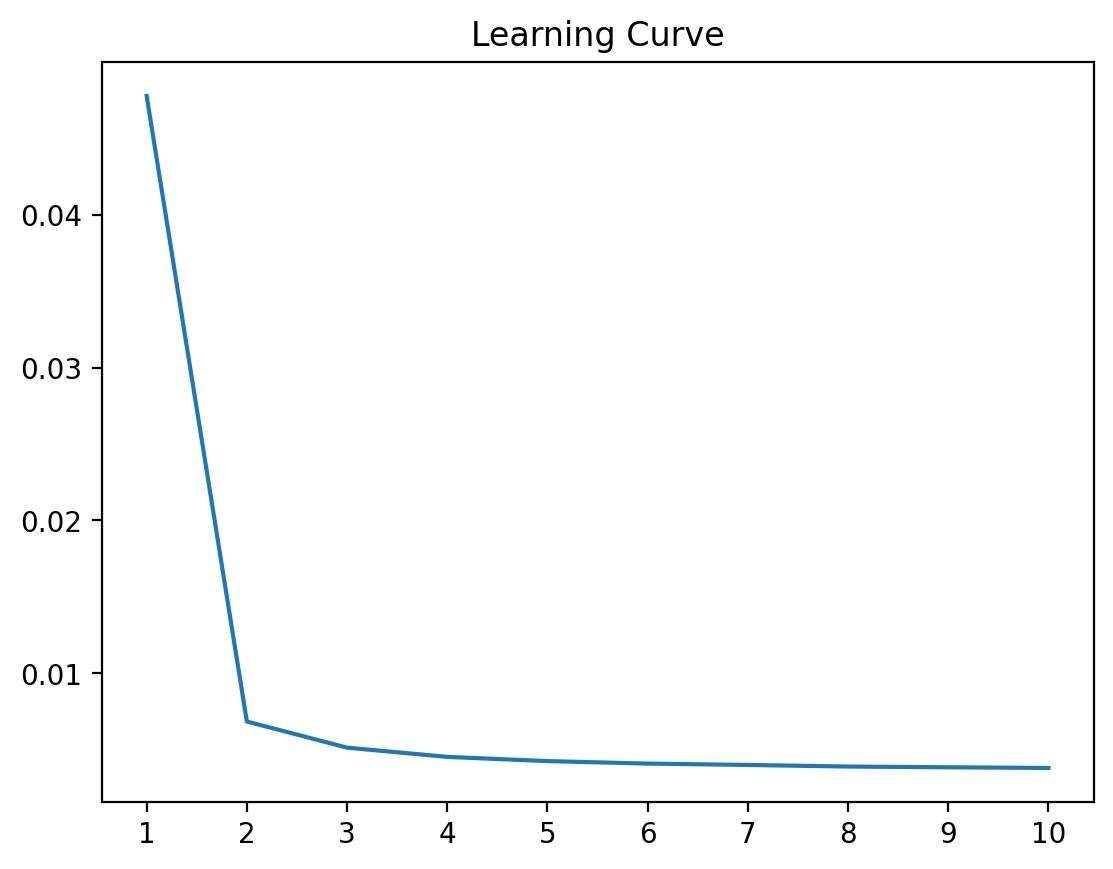

In [524]:
# The fit method returns a history object that
# can be used to plot the learning curve.

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

In [525]:
import random
import tqdm
import mlflow

# Initialize the parameters and ranges to test
runs = 15
learning_rate_logs = [random.uniform(-2, -5) for _ in range(runs)]
encoder_widths = [random.choice(range(150, 350, 30)) for _ in range(runs)]
parameters = list(zip(learning_rate_logs, encoder_widths))

best_loss = float('inf')
best_params = None

for (learning_rate_log, encoder_width) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        # Build and train the model with the current parameters
        autoencoder = build_model(encoder_width=encoder_width, learning_rate_log=learning_rate_log)
        history = train_denoise_model(autoencoder, epochs=25, verbose=0)
        for epoch in range(len(history.history['loss'])):
            mlflow.log_metric('train_loss', history.history['loss'][epoch], step=epoch)
            mlflow.log_metric('val_loss', history.history['val_loss'][epoch], step=epoch)

        # Get the loss from training
        final_loss = history.history['loss'][-1]  # Last epoch's loss
        
        # Log the parameters and loss to MLflow
        mlflow.log_param('learning_rate_log', learning_rate_log)
        mlflow.log_param('encoder_width', encoder_width)
        mlflow.log_metric('final_loss', final_loss)

        # Track the best parameters based on lowest loss
        if final_loss < best_loss:
            best_loss = final_loss
            best_params = (learning_rate_log, encoder_width)

# After all runs, log the best model's parameters
print(f"Best loss: {best_loss}, Best learning rate log: {best_params[0]}, Best encoder width: {best_params[1]}")


100%|██████████| 15/15 [18:23<00:00, 73.58s/it]

Best loss: 0.0033832001499831676, Best learning rate log: -3.191202365551119, Best encoder width: 300


In [531]:
# so that you don't accidentally train multiples models
import numpy as np
import tensorflow as tf
import mlflow

# Setting the seeds for reproducibility without resetting later
np.random.seed(11)
tf.random.set_seed(11)

# Assuming you have your model-building and training functions defined
# build_model() and train_denoise_model() should already exist

with mlflow.start_run():
    autoencoder = build_model(encoder_width=best_params[1], learning_rate_log=best_params[0])
    history = train_denoise_model(autoencoder, epochs=60)

    # Logging the loss at each epoch
    for epoch, loss in enumerate(history.history['loss']):
        print(f"Epoch {epoch + 1}, Loss: {loss}")
        mlflow.log_metric("loss", loss, step=epoch + 1)

    # Optionally, you can log the final model
    mlflow.keras.log_model(autoencoder, "autoencoder_model")

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60
Epoch 1, Loss: 0.05677412077784538
Epoch 2, Loss: 0.0070594605058431625
Epoch 3, Loss: 0.00509145762771368
Epoch 4, Loss: 0.004401871468871832
Epoch 5, Loss: 0.004091572482138872
Epoch 6, Loss: 0.003921902272850275
Epoch 7, Loss: 0.003819519653916359
Epoch 8, Loss: 0.003722282825037837
Ep

2024/10/06 22:07:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpt49_55zx/model/data/model/assets


2024/10/06 22:07:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [532]:
# This loads the last active run,
# but you probably want to load the best run from the experiment.
last_run = mlflow.last_active_run()
saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(last_run.info.run_id, 'model')
autoencoder = load_model(saved_model_path)

In [533]:
# Now we can feed the noisy images into the autoencoder.
test_denoised_X = autoencoder.predict(test_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
test_denoised_X = pd.DataFrame(test_denoised_X)

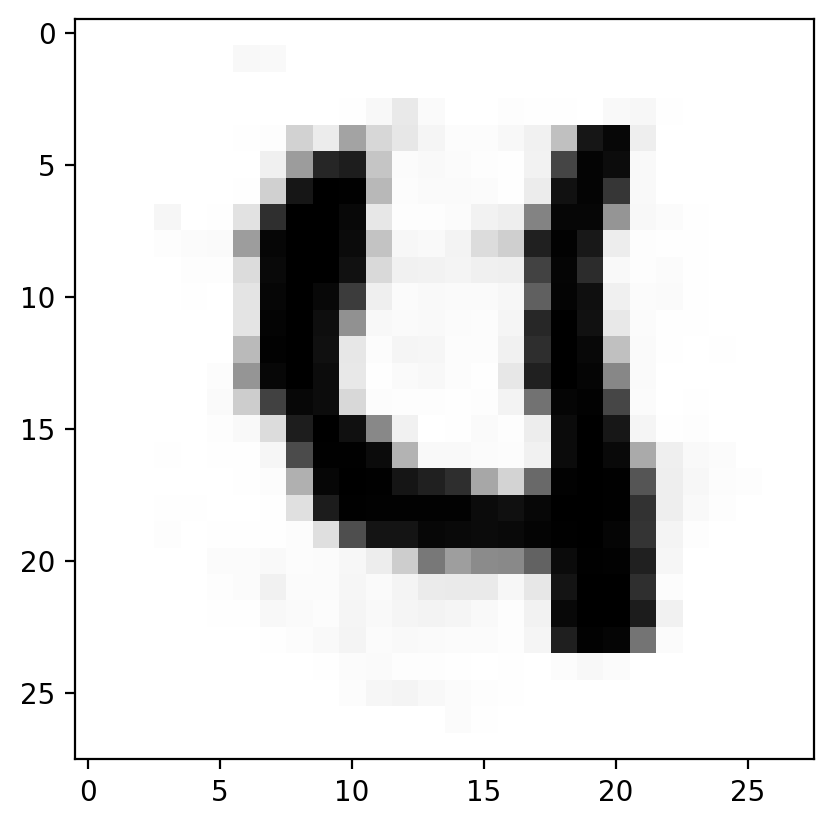

In [534]:
# Let's confirm that the denoiser works.
image_pixels = test_denoised_X.iloc[1]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [535]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(test_denoised_X, test_clean_X)

0.0034381049

In [537]:
import os 

model_path = 'assignment_submission'

os.makedirs(model_path, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_path}/score_denoised_x.parquet')

save_model(autoencoder, model_path)

# You now have the following files to be uploaded:
# 1. This notebook and any other Python code you used to train the final model.
# 2. architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset